Import Necessary Modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


Geolocation Integration

In [2]:
fraud = pd.read_csv('../data/raw/Fraud_Data.csv')
ip_df = pd.read_csv('../data/raw/IpAddress_to_Country.csv')


In [24]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [3]:
# Convert time-related columns to datetime format
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])

In [4]:
# convert ip_addresses to integer

fraud['ip_address'] = fraud['ip_address'].astype(np.int64)

ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype(np.int64)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype(np.int64)

In [5]:
# merging the two dataframes using range based lookup

ip_df = ip_df.sort_values('lower_bound_ip_address')
df = fraud.sort_values('ip_address')

fraud = pd.merge_asof(
    df,
    ip_df,
    left_on='ip_address',
    right_on='lower_bound_ip_address',
    direction='backward'
)

fraud = fraud[fraud['ip_address'] <= fraud['upper_bound_ip_address']]

In [6]:
fraud.groupby('country')['class'].mean().sort_values(ascending=False).head(10) # top 10 countries with higher fraud cases based on class

country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64

Feature Engineering

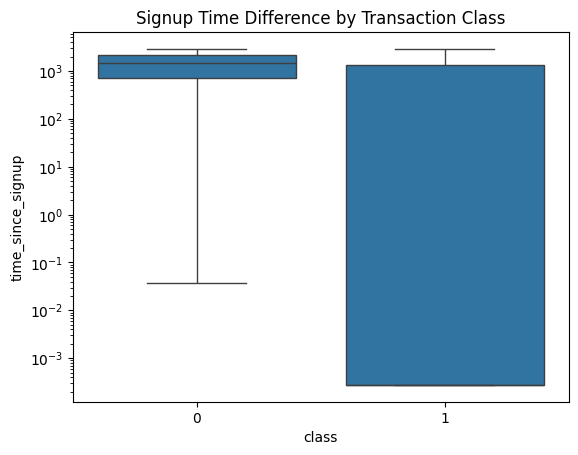

In [7]:
fraud['time_since_signup'] = (fraud['purchase_time'] - fraud['signup_time']).dt.total_seconds() / 3600.0 # convert to hours
fraud['hour_of_day'] = fraud['purchase_time'].dt.hour
fraud['day_of_week'] = fraud['purchase_time'].dt.dayofweek

sns.boxplot(x='class', y='time_since_signup', data=fraud)
plt.title('Signup Time Difference by Transaction Class')
plt.yscale('log')
plt.show()

In [8]:
# Ensure correct sort
fraud = fraud.sort_values(['user_id', 'purchase_time']).reset_index(drop=True)
# Initialize the column
fraud['txn_count_1h'] = 0
# Process each user separately
for user_id, group in fraud.groupby('user_id'):
   times = group['purchase_time'].values.astype('datetime64[s]')
   counts = np.zeros(len(times), dtype=int)
   start_idx = 0
   for i in range(len(times)):
       # Move the window start index forward until transactions are within 1 hour
       while times[i] - times[start_idx] > np.timedelta64(1, 'h'):
           start_idx += 1
       counts[i] = i - start_idx + 1
   # Assign counts back to main dataframe
   fraud.loc[group.index, 'txn_count_1h'] = counts

In [47]:
fraud.head(10)
# Each user made one transaction so it's showing 1 for count of transactions within one hour

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country,time_since_signup,hour_of_day,day_of_week,txn_count_1h
0,2,2015-01-11 03:47:13,2015-02-21 10:03:37,54,FGBQNDNBETFJJ,SEO,Chrome,F,25,880217484,0,8.724152e+08,8.891924e+08,United States,990.273333,10,5,1
1,4,2015-06-02 16:40:57,2015-09-26 21:32:16,41,MKFUIVOHLJBYN,Direct,Safari,F,38,2785906106,0,2.785542e+09,2.786066e+09,Switzerland,2788.855278,21,5,1
2,8,2015-05-28 07:53:06,2015-08-13 11:53:07,47,SCQGQALXBUQZJ,SEO,Chrome,M,25,356056736,0,3.523215e+08,3.690988e+08,United States,1852.000278,11,3,1
3,12,2015-01-10 06:25:12,2015-03-04 20:56:37,35,MSNWCFEHKTIOY,Ads,Safari,M,19,2985180352,0,2.985034e+09,2.985296e+09,Mexico,1286.523611,20,2,1
4,16,2015-02-03 13:48:23,2015-03-12 12:46:23,9,FROZWSSWOHZBE,Direct,IE,M,32,578312545,0,5.704253e+08,5.872026e+08,United States,886.966667,12,3,1
5,18,2015-07-06 09:26:20,2015-10-23 00:18:57,11,VHRJLKVGGBXOI,SEO,IE,M,39,3647502435,0,3.647472e+09,3.647504e+09,Netherlands,2606.876944,0,4,1
6,33,2015-08-10 08:30:49,2015-10-28 18:12:41,51,VVQLOMBTOWVDD,Direct,Chrome,F,32,1202326461,0,1.202323e+09,1.202455e+09,United States,1905.697778,18,2,1
7,39,2015-01-08 18:13:25,2015-01-08 18:13:26,31,FXOJBYSUTLWZX,SEO,Chrome,F,50,3142341272,1,3.142320e+09,3.142582e+09,Brazil,0.000278,18,3,1
8,41,2015-01-30 06:43:52,2015-03-23 10:10:08,55,MWDRTHVZSRNWR,Ads,IE,F,28,1649831629,0,1.648361e+09,1.650459e+09,United States,1251.437778,10,0,1
9,47,2015-02-10 08:47:58,2015-04-04 09:08:26,33,TXTWPZADPROFR,SEO,Chrome,M,30,3551345192,0,3.551265e+09,3.551527e+09,Korea Republic of,1272.341111,9,5,1


Data transformation

In [32]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129146 entries, 0 to 129145
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   user_id                 129146 non-null  int64         
 1   signup_time             129146 non-null  datetime64[ns]
 2   purchase_time           129146 non-null  datetime64[ns]
 3   purchase_value          129146 non-null  int64         
 4   device_id               129146 non-null  object        
 5   source                  129146 non-null  object        
 6   browser                 129146 non-null  object        
 7   sex                     129146 non-null  object        
 8   age                     129146 non-null  int64         
 9   ip_address              129146 non-null  int64         
 10  class                   129146 non-null  int64         
 11  lower_bound_ip_address  129146 non-null  float64       
 12  upper_bound_ip_address  129146

In [9]:
# normalizing numeric values (exclude target 'class')

numeric_cols = [c for c in fraud.select_dtypes(include=["int64", "float64"]).columns.tolist() if c != 'class']
scaler = StandardScaler()
fraud[numeric_cols] = scaler.fit_transform(fraud[numeric_cols])

fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,country,time_since_signup,hour_of_day,day_of_week,txn_count_1h
0,-1.734844,2015-01-11 03:47:13,2015-02-21 10:03:37,0.931750,FGBQNDNBETFJJ,SEO,Chrome,F,-0.943490,-0.933077,0,-0.937189,-0.927856,United States,-0.435282,10,5,0.0
1,-1.734826,2015-06-02 16:40:57,2015-09-26 21:32:16,0.222055,MKFUIVOHLJBYN,Direct,Safari,F,0.565460,0.822989,0,0.823144,0.822623,Switzerland,1.633628,21,5,0.0
2,-1.734792,2015-05-28 07:53:06,2015-08-13 11:53:07,0.549607,SCQGQALXBUQZJ,SEO,Chrome,M,-0.943490,-1.416084,0,-1.415745,-1.407811,United States,0.555963,11,3,0.0
3,-1.734757,2015-01-10 06:25:12,2015-03-04 20:56:37,-0.105497,MSNWCFEHKTIOY,Ads,Safari,M,-1.639928,1.006618,0,1.006703,1.006477,Mexico,-0.094505,20,2,0.0
4,-1.734722,2015-02-03 13:48:23,2015-03-12 12:46:23,-1.524887,FROZWSSWOHZBE,Direct,IE,M,-0.130978,-1.211278,0,-1.215060,-1.206539,United States,-0.554116,12,3,0.0


In [10]:
# cardinality-aware encoding: one-hot for low-cardinality, frequency for high-cardinality
categorical_cols = [c for c in fraud.select_dtypes(include=["object"]).columns.tolist() if c != 'class']
if categorical_cols:
    fraud[categorical_cols] = fraud[categorical_cols].fillna('missing').astype(str)
    nunique = fraud[categorical_cols].nunique()
    threshold = 30  # max unique values to one-hot encode (adjustable)
    low_card = nunique[nunique <= threshold].index.tolist()
    high_card = nunique[nunique > threshold].index.tolist()
    # frequency-encode high-cardinality columns to avoid explosion in columns
    for col in high_card:
        freq = fraud[col].value_counts(normalize=True)
        fraud[f'{col}_freq'] = fraud[col].map(freq)
    # one-hot encode low-cardinality columns (if any)
    if low_card:
        try:
            try:
                ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
            except TypeError:
                ohe = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
            encoded = ohe.fit_transform(fraud[low_card])
            cols = ohe.get_feature_names_out(low_card)
            encoded_df = pd.DataFrame(encoded, columns=cols, index=fraud.index)
        except Exception:
            encoded_df = pd.get_dummies(fraud[low_card].astype(str), prefix=low_card, drop_first=True)
        fraud = pd.concat([fraud.drop(columns=low_card), encoded_df], axis=1)
    else:
        # if no low-cardinality cols, drop originals for high-card cols (we already added freq cols)
        fraud = fraud.drop(columns=high_card)
else:
    encoded_df = pd.DataFrame(index=fraud.index)
# quick summary to help debug memory issues
print(f'Categorical columns: {len(categorical_cols)}, low_card: {len(low_card) if categorical_cols else 0}, high_card: {len(high_card) if categorical_cols else 0}')
print(high_card)

Categorical columns: 5, low_card: 3, high_card: 2
['device_id', 'country']


In [35]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,...,txn_count_1h,device_id_freq,country_freq,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,-1.734844,2015-01-11 03:47:13,2015-02-21 10:03:37,0.931750,FGBQNDNBETFJJ,-0.943490,-0.933077,0,-0.937189,-0.927856,...,0.0,0.000008,0.449484,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.734826,2015-06-02 16:40:57,2015-09-26 21:32:16,0.222055,MKFUIVOHLJBYN,0.565460,0.822989,0,0.823144,0.822623,...,0.0,0.000008,0.006078,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.734792,2015-05-28 07:53:06,2015-08-13 11:53:07,0.549607,SCQGQALXBUQZJ,-0.943490,-1.416084,0,-1.415745,-1.407811,...,0.0,0.000008,0.449484,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-1.734757,2015-01-10 06:25:12,2015-03-04 20:56:37,-0.105497,MSNWCFEHKTIOY,-1.639928,1.006618,0,1.006703,1.006477,...,0.0,0.000008,0.008680,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,-1.734722,2015-02-03 13:48:23,2015-03-12 12:46:23,-1.524887,FROZWSSWOHZBE,-0.130978,-1.211278,0,-1.215060,-1.206539,...,0.0,0.000008,0.449484,1.0,0.0,0.0,1.0,0.0,0.0,1.0


Handle Class Imbalance

In [50]:
X = fraud.drop(columns=['class'])
y = fraud['class']

# drop datetime columns and any remaining non-numeric columns before modeling
dt_cols = X.select_dtypes(include=['datetime64[ns]', 'datetime64']).columns.tolist()
if dt_cols:
    X = X.drop(columns=dt_cols)
    print(f'Dropped datetime columns: {dt_cols}')
non_numeric = X.select_dtypes(exclude=[np.number]).columns.tolist()
if non_numeric:
    print(f'Dropping non-numeric columns before train/test: {non_numeric}')
    X = X.drop(columns=non_numeric)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Dropped datetime columns: ['signup_time', 'purchase_time']
Dropping non-numeric columns before train/test: ['device_id', 'country']


In [51]:
class_counts = y_train.value_counts(normalize=True)
print("Class Distribution:\n", class_counts)

Class Distribution:
 class
0    0.90501
1    0.09499
Name: proportion, dtype: float64


In [52]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [55]:
class_counts = y_train_res.value_counts(normalize=True)
print("Class Distribution:\n", class_counts)

Class Distribution:
 class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [56]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,lower_bound_ip_address,upper_bound_ip_address,...,txn_count_1h,device_id_freq,country_freq,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M
0,-1.734844,2015-01-11 03:47:13,2015-02-21 10:03:37,0.931750,FGBQNDNBETFJJ,-0.943490,-0.933077,0,-0.937189,-0.927856,...,0.0,0.000008,0.449484,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.734826,2015-06-02 16:40:57,2015-09-26 21:32:16,0.222055,MKFUIVOHLJBYN,0.565460,0.822989,0,0.823144,0.822623,...,0.0,0.000008,0.006078,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.734792,2015-05-28 07:53:06,2015-08-13 11:53:07,0.549607,SCQGQALXBUQZJ,-0.943490,-1.416084,0,-1.415745,-1.407811,...,0.0,0.000008,0.449484,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-1.734757,2015-01-10 06:25:12,2015-03-04 20:56:37,-0.105497,MSNWCFEHKTIOY,-1.639928,1.006618,0,1.006703,1.006477,...,0.0,0.000008,0.008680,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,-1.734722,2015-02-03 13:48:23,2015-03-12 12:46:23,-1.524887,FROZWSSWOHZBE,-0.130978,-1.211278,0,-1.215060,-1.206539,...,0.0,0.000008,0.449484,1.0,0.0,0.0,1.0,0.0,0.0,1.0


SMOTE was applied to the training set only in order to prevent information leakage while improving minority-class recall.

In [59]:
fraud.to_csv('../data/processed/fraud_processed.csv', index=False)
